In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crop-yield-prediction-dataset/yield.csv
/kaggle/input/crop-yield-prediction-dataset/temp.csv
/kaggle/input/crop-yield-prediction-dataset/rainfall.csv
/kaggle/input/crop-yield-prediction-dataset/pesticides.csv
/kaggle/input/crop-yield-prediction-dataset/yield_df.csv


In [2]:
import numpy as np 
import math
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

In [3]:
cropData = pd.read_csv('/kaggle/input/crop-yield-prediction-dataset/yield_df.csv')
print(cropData.head())

   Unnamed: 0     Area         Item  Year  hg/ha_yield  \
0           0  Albania        Maize  1990        36613   
1           1  Albania     Potatoes  1990        66667   
2           2  Albania  Rice, paddy  1990        23333   
3           3  Albania      Sorghum  1990        12500   
4           4  Albania     Soybeans  1990         7000   

   average_rain_fall_mm_per_year  pesticides_tonnes  avg_temp  
0                         1485.0              121.0     16.37  
1                         1485.0              121.0     16.37  
2                         1485.0              121.0     16.37  
3                         1485.0              121.0     16.37  
4                         1485.0              121.0     16.37  


In [4]:
cropData.dropna(axis=0)
cropData = cropData.drop(['Unnamed: 0'], axis=1) # Dropping Unnamed column to not create bias.
cropData.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [5]:
le = LabelEncoder()
for col in ['Area', 'Item']:
    cropData.loc[:, col] = le.fit_transform(cropData[col])

cropData.head()

,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,1,1990,36613,1485.0,121.0,16.37
1,0,3,1990,66667,1485.0,121.0,16.37
2,0,4,1990,23333,1485.0,121.0,16.37
3,0,5,1990,12500,1485.0,121.0,16.37
4,0,6,1990,7000,1485.0,121.0,16.37


In [6]:
# A. Temporal Splitting (Year-Based)
data_sorted = cropData.sort_values(by='Year')

# Combine train and validation years
train_val_temp = data_sorted[data_sorted['Year'] <= 2011]  # Up to 2011 inclusive
test_temp = data_sorted[data_sorted['Year'] > 2011]
print(train_val_temp.head())
print("\n\n")
print(test_temp.head())

      Area Item  Year  hg/ha_yield  average_rain_fall_mm_per_year  \
0        0    1  1990        36613                         1485.0   
14575   43    6  1990        11149                         2702.0   
14576   43    6  1990        11149                         2702.0   
14577   43    6  1990        11149                         2702.0   
14578   43    6  1990        11149                         2702.0   

       pesticides_tonnes  avg_temp  
0                  121.0     16.37  
14575             2432.0     27.05  
14576             2432.0     27.11  
14577             2432.0     27.18  
14578             2432.0     26.79  



      Area Item  Year  hg/ha_yield  average_rain_fall_mm_per_year  \
14218   42    0  2012       385818                         1083.0   
6900    22    0  2012        96365                         3240.0   
6904    22    2  2012        80883                         3240.0   
6905    22    3  2012       181661                         3240.0   
6906    22    3

In [7]:
# Split train_val into train and validation
# data before 2012
train_temp_X = train_val_temp.drop(['hg/ha_yield'], axis=1)
train_temp_y = train_val_temp['hg/ha_yield']

# datas after 2011
test_temp_X = test_temp.drop(['hg/ha_yield'], axis=1)
test_temp_y = test_temp['hg/ha_yield']

In [8]:
scaler_temp_X = StandardScaler()

scaler_temp_X.fit(train_temp_X)

train_temp_X_scaled = scaler_temp_X.transform(train_temp_X)
test_temp_X_scaled = scaler_temp_X.transform(test_temp_X)

train_temp_X_scaled = pd.DataFrame(train_temp_X_scaled, columns=train_temp_X.columns, index=train_temp_X.index)
test_temp_X_scaled = pd.DataFrame(test_temp_X_scaled, columns=test_temp_X.columns, index=test_temp_X.index)


In [9]:
unique_areas = cropData['Area'].unique()

# Calculate number of areas for train/val split (75%)
num_train_val_areas = int(0.75 * len(unique_areas))

# Randomly select areas for train/val
np.random.seed(42)  # For reproducibility
train_val_areas = np.random.choice(unique_areas, size=num_train_val_areas, replace=False)
test_areas = np.setdiff1d(unique_areas, train_val_areas)

# Filter data based on chosen areas
train_val_spatial = cropData[cropData['Area'].isin(train_val_areas)]
test_spatial = cropData[cropData['Area'].isin(test_areas)]

# Split train_val into train and validation (optional)
train_spatial_X = train_val_spatial.drop(['hg/ha_yield'], axis=1)
train_spatial_y = train_val_spatial['hg/ha_yield']

test_spatial_X = test_spatial.drop(['hg/ha_yield'], axis=1)
test_spatial_y = test_spatial['hg/ha_yield']


In [10]:
scaler_spatial_X = StandardScaler()
scaler_spatial_X.fit(train_spatial_X)

train_spatial_X_scaled = scaler_spatial_X.transform(train_spatial_X)
test_spatial_X_scaled = scaler_spatial_X.transform(test_spatial_X)

train_spatial_X_scaled = pd.DataFrame(train_spatial_X_scaled, columns=train_spatial_X.columns, index=train_spatial_X.index)
test_spatial_X_scaled = pd.DataFrame(test_spatial_X_scaled, columns=test_spatial_X.columns, index=test_spatial_X.index)


In [11]:
train_temp_X_lstm, val_temp_X_lstm, train_temp_y_lstm, val_temp_y_lstm = train_test_split (train_temp_X_scaled, train_temp_y, test_size=0.1, random_state=42, shuffle=False)

In [12]:
train_temp_X_3d = np.reshape(train_temp_X_lstm.values, (train_temp_X_lstm.shape[0], 1, train_temp_X_lstm.shape[1]))
val_temp_X_3d = np.reshape(val_temp_X_lstm.values, (val_temp_X_lstm.shape[0], 1, val_temp_X_lstm.shape[1]))

# Check the shape to ensure it is correct
print(f"Shape of train_temp_X_3d: {train_temp_X_3d.shape}")
print(f"Shape of val_temp_X_3d: {val_temp_X_3d.shape}")

Shape of train_temp_X_3d: (23150, 1, 6)
Shape of val_temp_X_3d: (2573, 1, 6)


In [13]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# Add Input layer
model.add(Input(shape=(train_temp_X_3d.shape[1], train_temp_X_3d.shape[2])))

# First LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=True))  # return_sequences=True to pass sequences to the next layer
model.add(Dropout(0.2))

# Second LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with 32 units
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))

# Fourth LSTM layer with 32 units
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))

# Fifth LSTM layer with 16 units (moving down in size)
model.add(LSTM(units=16, return_sequences=False))  # return_sequences=False for the final layer
model.add(Dropout(0.2))

# Dense output layer with linear activation (default for regression tasks)
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 64)               │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 1, 32)               │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,089 (293.32 KB)

 Trainable params: 75,089 (293.32 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the LSTM model
history = model.fit(train_temp_X_3d, train_temp_y_lstm, epochs=30, batch_size=32, validation_data=(val_temp_X_3d, val_temp_y_lstm))

Epoch 1/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 12221774848.0000 - val_loss: 16530407424.0000
Epoch 2/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 12361339904.0000 - val_loss: 16528743424.0000
Epoch 3/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 12304591872.0000 - val_loss: 16527101952.0000
Epoch 4/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 12641383424.0000 - val_loss: 16525483008.0000
Epoch 5/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 12124788736.0000 - val_loss: 16523850752.0000
Epoch 6/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 12520643584.0000 - val_loss: 16522230784.0000
Epoch 7/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 12432075776.0000 - val_loss: 16520603648.0000
Epoch 8/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 12070426624.0000 - val_loss: 16518981632.0000
Epoch 9/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 12113077248.0000 - val_loss: 16517348352.0000
Epoch 10/30
724/724 ━━━━━━━━━━━━━━━━━━━━ 4s 6

In [15]:
# Make predictions on the test data
test_temp_X_3d = np.reshape(test_temp_X_scaled.values, (test_temp_X_scaled.shape[0], 1, test_temp_X_scaled.shape[1]))

predictions_temp = model.predict(test_temp_X_3d)

# Invert the scaling if needed (to get the actual values back, assuming your target was also scaled)
# predictions_temp = scaler_temp_y.inverse_transform(predictions_temp)  # If you used a scaler for target variable

# Print the first few predictions
print(predictions_temp[:5])


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[[284.75516]
 [284.75516]
 [284.75516]
 [284.75516]
 [284.75516]]


In [16]:
# Evaluate the model performance

print(test_temp_y.shape, predictions_temp.shape)
mae = mean_absolute_error(test_temp_y, predictions_temp)
mse = mean_squared_error(test_temp_y, predictions_temp)
rmse = np.sqrt(mse)
r2 = r2_score(test_temp_y, predictions_temp)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (MSE): {rmse}")
print(f"R² Score: {r2}")


(2519,) (2519, 1)
Mean Absolute Error (MAE): 89178.49732367261
Mean Squared Error (MSE): 17193977690.258587
Root Mean Squared Error (MSE): 131125.8086352896
R² Score: -0.860583837368778


Temporal Graphs

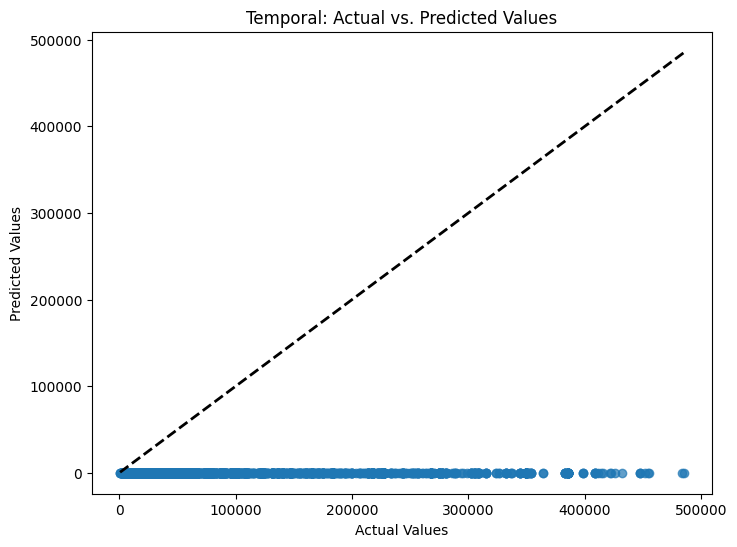

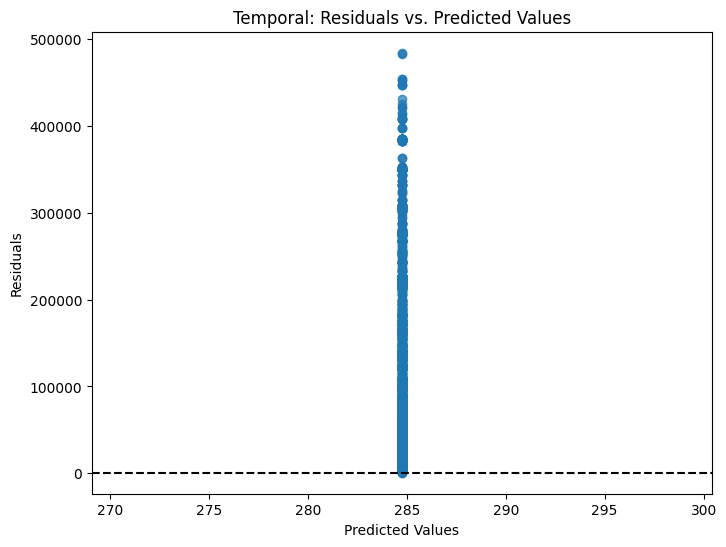

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


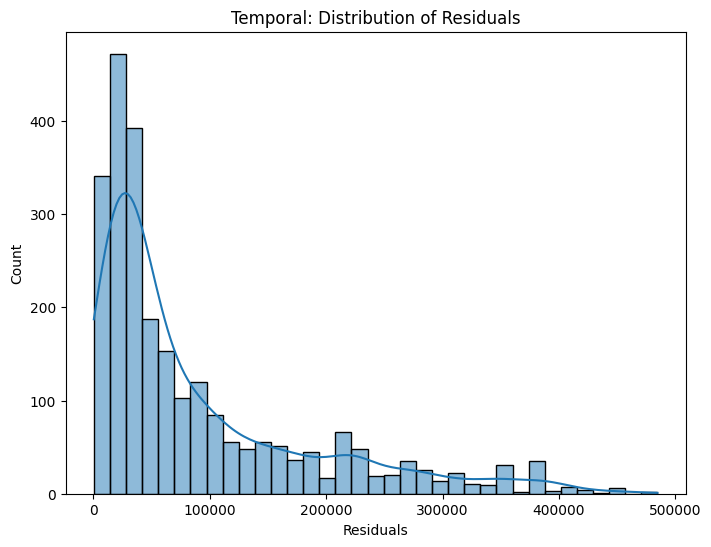

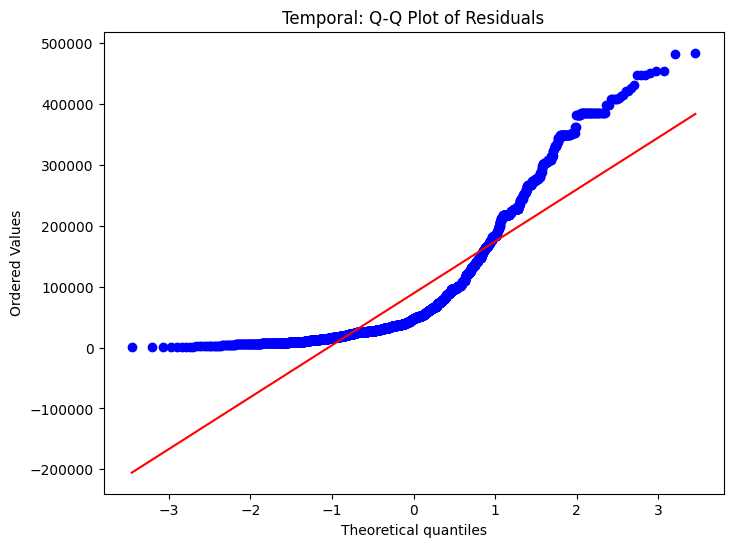

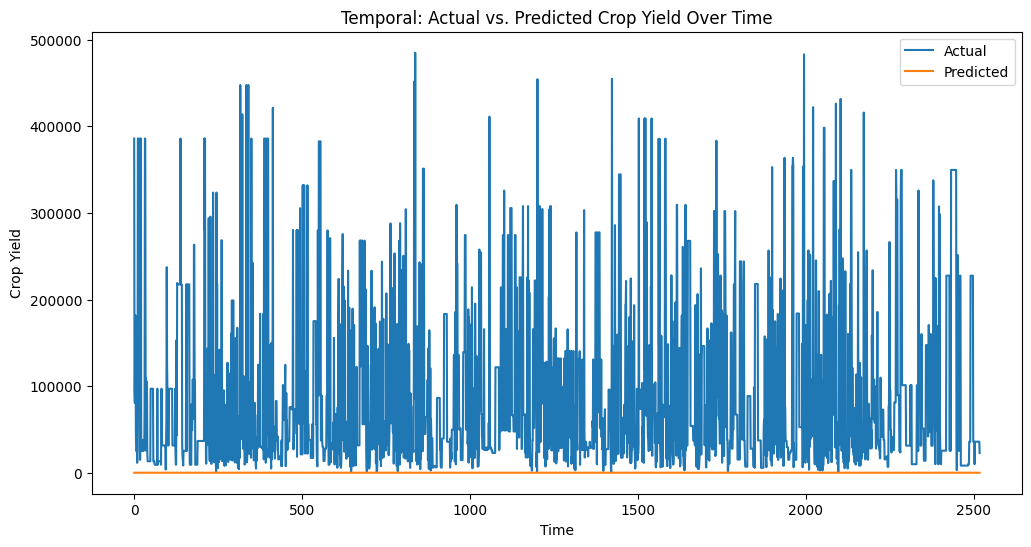

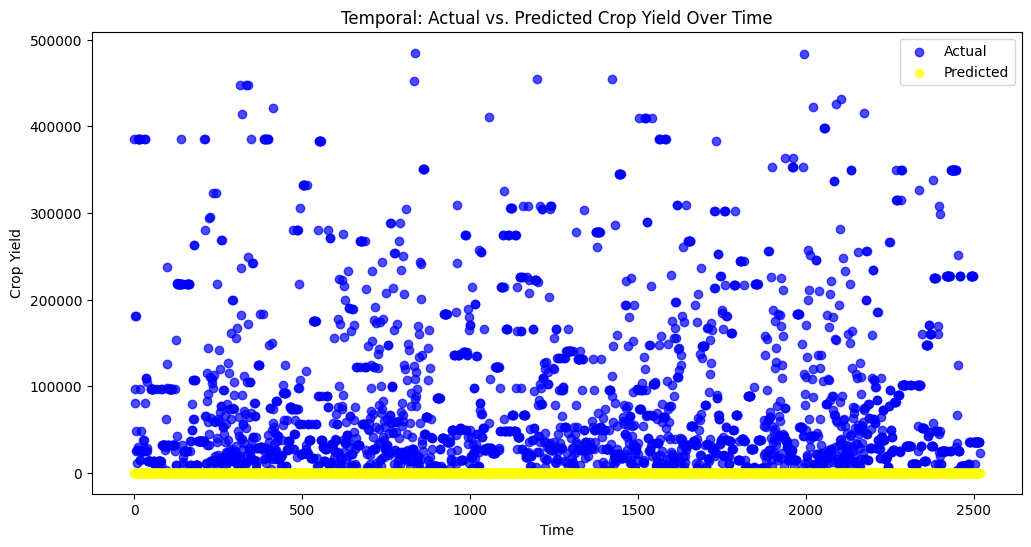

In [17]:
# Plots for TEMPORAL model
# Actual vs. Predicted Values (Scatter Plot)
plt.figure(figsize=(8, 6))
plt.scatter(test_temp_y, predictions_temp, alpha=0.7)
plt.plot([test_temp_y.min(), test_temp_y.max()], [test_temp_y.min(), test_temp_y.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Temporal: Actual vs. Predicted Values")  # Added Temporal to the title
plt.show()

# Extract values as NumPy arrays
test_temp_flat = test_temp_y.values.flatten()  # Convert to a 1D NumPy array
predictions_flat = predictions_temp.flatten()  # Convert to a 1D array

# Calculate residuals
residuals_temp = test_temp_flat - predictions_flat

# Residuals vs. Predicted Values (Residual Plot)
plt.figure(figsize=(8, 6))
plt.scatter(predictions_flat, residuals_temp, alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Temporal: Residuals vs. Predicted Values")  # Added Temporal to the title
plt.show()

# Distribution of Residuals (Histogram or KDE)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_temp, kde=True)
plt.xlabel("Residuals")
plt.title("Temporal: Distribution of Residuals")  # Added Temporal to the title
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
plt.figure(figsize=(8, 6))
stats.probplot(residuals_temp, dist="norm", plot=plt)
plt.title("Temporal: Q-Q Plot of Residuals")  # Added Temporal to the title
plt.show()

# Create DataFrame for predictions and actuals
predictions_df_temp = pd.DataFrame({"Actual": test_temp_y.values.flatten(), "Predicted": predictions_temp.flatten()})

# Line plot for Prediction Error
plt.figure(figsize=(12, 6))
plt.plot(predictions_df_temp.index, predictions_df_temp["Actual"], label="Actual")
plt.plot(predictions_df_temp.index, predictions_df_temp["Predicted"], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Crop Yield")
plt.title("Temporal: Actual vs. Predicted Crop Yield Over Time")  # Added Temporal to the title
plt.legend()
plt.show()

# Scatter plot for actual vs predicted over time
plt.figure(figsize=(12, 6))
plt.scatter(predictions_df_temp.index, predictions_df_temp["Actual"], label="Actual", color="blue", alpha=0.7)
plt.scatter(predictions_df_temp.index, predictions_df_temp["Predicted"], label="Predicted", color="yellow", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Crop Yield")
plt.title("Temporal: Actual vs. Predicted Crop Yield Over Time")  # Added Temporal to the title
plt.legend()
plt.show()


**Spatial Data**

In [18]:
train_spatial_X_lstm, val_spatial_X_lstm, train_spatial_y_lstm, val_spatial_y_lstm = train_test_split(train_spatial_X_scaled, train_spatial_y, test_size=0.1, random_state=42, shuffle=False)

In [19]:
train_spatial_X_3d = np.reshape(train_spatial_X_lstm.values, (train_spatial_X_lstm.shape[0], 1, train_spatial_X_lstm.shape[1]))
val_spatial_X_3d = np.reshape(val_spatial_X_lstm.values, (val_spatial_X_lstm.shape[0], 1, val_spatial_X_lstm.shape[1]))

# Check the shape to ensure it is correct
print(f"Shape of train_spatial_X_3d: {train_spatial_X_3d.shape}")
print(f"Shape of val_spatial_X_3d: {val_spatial_X_3d.shape}")

Shape of train_spatial_X_3d: (19889, 1, 6)
Shape of val_spatial_X_3d: (2210, 1, 6)


In [20]:
# Build the LSTM model
model = Sequential()

model.add(Input(shape=(train_spatial_X_3d.shape[1], train_spatial_X_3d.shape[2])))

# First LSTM layer with 64 units and return_sequences=True for the next LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(train_spatial_X_3d.shape[1], train_spatial_X_3d.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer with 64 units and return_sequences=True
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with 32 units and return_sequences=True
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))

# Fourth LSTM layer with 32 units and return_sequences=False (final layer)
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Dense output layer with linear activation (for regression)
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary to check the architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 1, 64)               │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 1, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 1, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,969 (281.13 KB)

 Trainable params: 71,969 (281.13 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the LSTM model
history = model.fit(train_spatial_X_3d, train_spatial_y_lstm, epochs=30, batch_size=32, validation_data=(val_spatial_X_3d, val_spatial_y_lstm))

Epoch 1/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 13456290816.0000 - val_loss: 20639637504.0000
Epoch 2/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 13506668544.0000 - val_loss: 20636790784.0000
Epoch 3/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 13497432064.0000 - val_loss: 20633989120.0000
Epoch 4/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 13581577216.0000 - val_loss: 20631212032.0000
Epoch 5/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 13617305600.0000 - val_loss: 20628447232.0000
Epoch 6/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 13447324672.0000 - val_loss: 20625688576.0000
Epoch 7/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 13397862400.0000 - val_loss: 20622934016.0000
Epoch 8/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 13667090432.0000 - val_loss: 20620185600.0000
Epoch 9/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 13773512704.0000 - val_loss: 20617426944.0000
Epoch 10/30
622/622 ━━━━━━━━━━━━━━━━━━━━ 3s 5m

In [22]:
test_spatial_X_3d = np.reshape(test_spatial_X_scaled.values, (test_spatial_X_scaled.shape[0], 1, test_spatial_X_scaled.shape[1]))

# Make predictions on the test data
predictions_spatial = model.predict(test_spatial_X_3d)

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [23]:
# Evaluate the model performance
print(test_spatial_y.shape)
print(predictions_spatial.shape)
mae = mean_absolute_error(test_spatial_y, predictions_spatial)
mse = mean_squared_error(test_spatial_y, predictions_spatial)
rmse = np.sqrt(mse)
r2 = r2_score(test_spatial_y, predictions_spatial)
# residuals_spatial = test_spatial_y - predictions_spatial 

print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R-squared: {r2}")

(6143,)
(6143, 1)
MSE: 9330730957.167011, RMSE: 96595.70879271507, MAE: 68289.67860899697, R-squared: -0.9991921265158783


** Spatial Graphs **

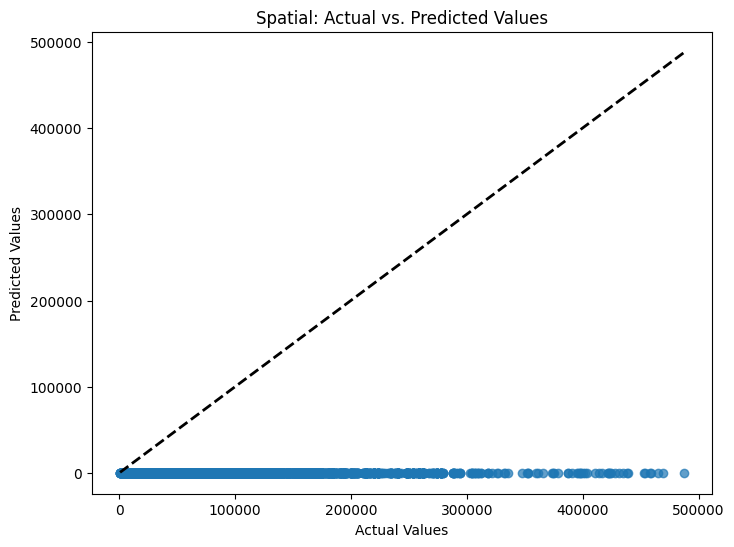

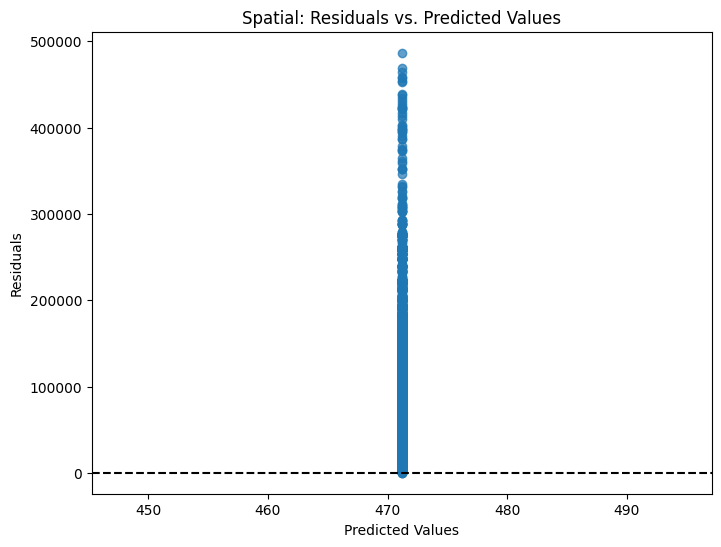

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


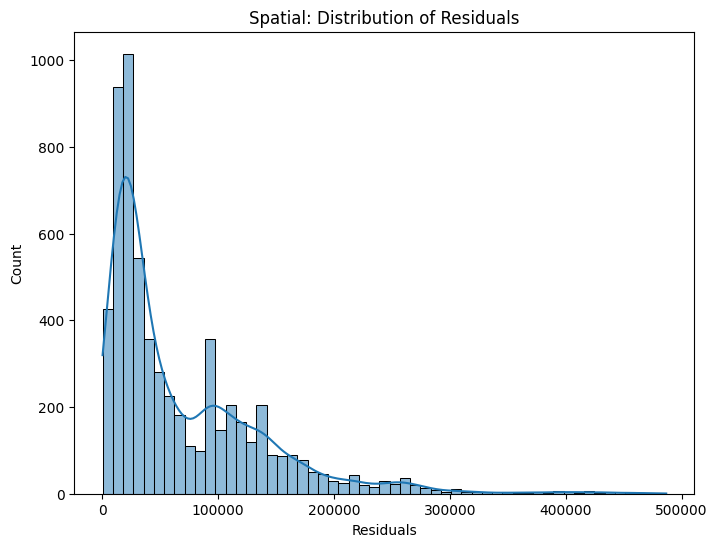

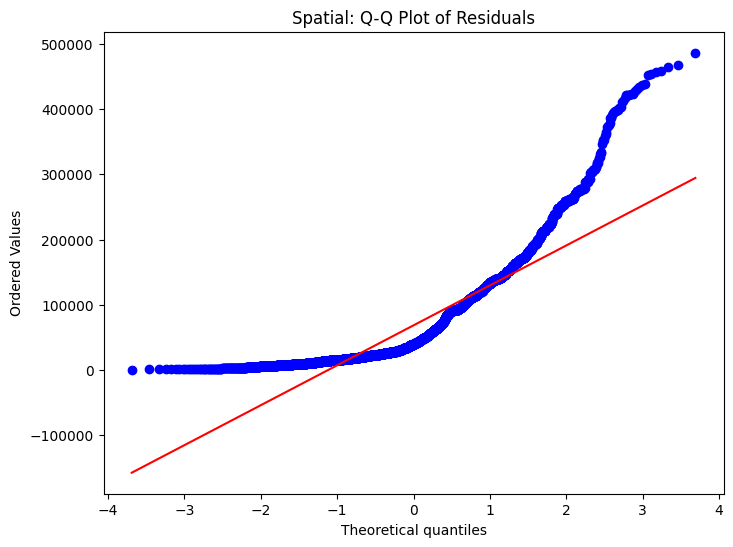

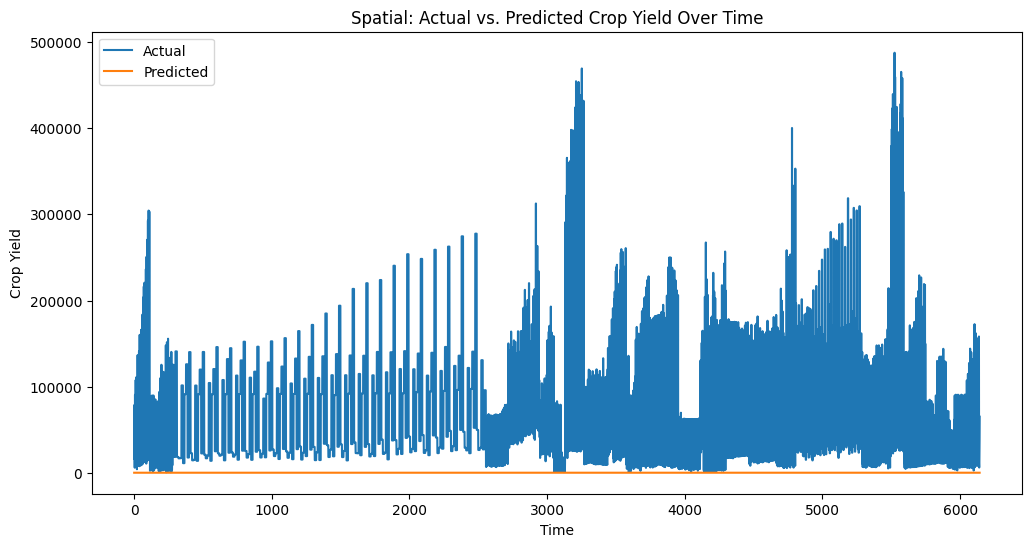

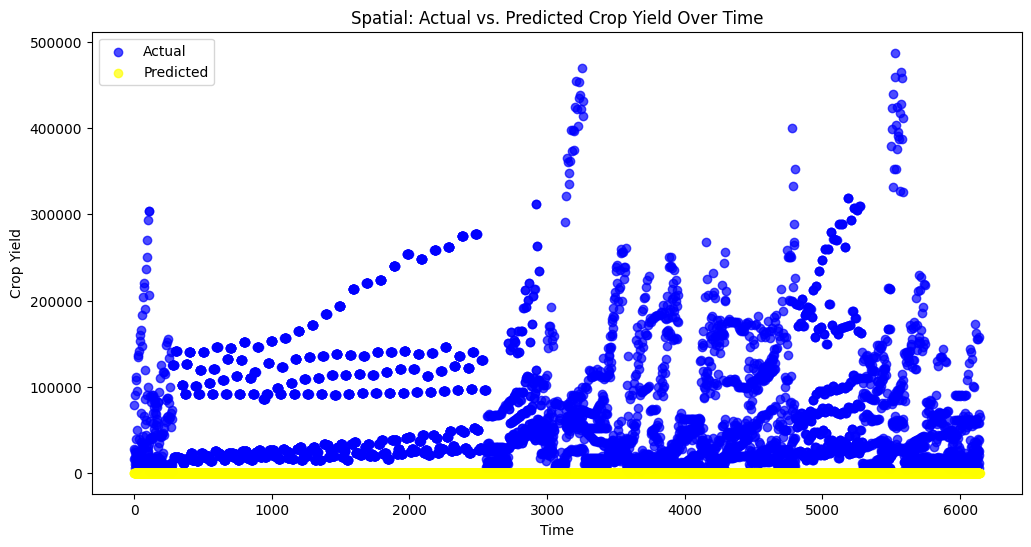

In [24]:
# Plots for TEMPORAL model
# Actual vs. Predicted Values (Scatter Plot)
plt.figure(figsize=(8, 6))
plt.scatter(test_spatial_y, predictions_spatial, alpha=0.7)
plt.plot([test_spatial_y.min(), test_spatial_y.max()], [test_spatial_y.min(), test_spatial_y.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Spatial: Actual vs. Predicted Values")  # Added Spatial to the title
plt.show()

# Extract values as NumPy arrays
test_spatial_flat = test_spatial_y.values.flatten()  # Convert to a 1D NumPy array
predictions_flat = predictions_spatial.flatten()  # Convert to a 1D array

# Calculate residuals
residuals_spatial = test_spatial_flat - predictions_flat

# Residuals vs. Predicted Values (Residual Plot)
plt.figure(figsize=(8, 6))
plt.scatter(predictions_flat, residuals_spatial, alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Spatial: Residuals vs. Predicted Values")  # Added Spatial to the title
plt.show()

# Distribution of Residuals (Histogram or KDE)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_spatial, kde=True)
plt.xlabel("Residuals")
plt.title("Spatial: Distribution of Residuals")  # Added Spatial to the title
plt.show()

# Q-Q Plot (Quantile-Quantile Plot)
plt.figure(figsize=(8, 6))
stats.probplot(residuals_spatial, dist="norm", plot=plt)
plt.title("Spatial: Q-Q Plot of Residuals")  # Added Spatial to the title
plt.show()

# Create DataFrame for predictions and actuals
predictions_df_spatial = pd.DataFrame({"Actual": test_spatial_y.values.flatten(), "Predicted": predictions_spatial.flatten()})

# Line plot for Prediction Error
plt.figure(figsize=(12, 6))
plt.plot(predictions_df_spatial.index, predictions_df_spatial["Actual"], label="Actual")
plt.plot(predictions_df_spatial.index, predictions_df_spatial["Predicted"], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Crop Yield")
plt.title("Spatial: Actual vs. Predicted Crop Yield Over Time")  # Added Spatial to the title
plt.legend()
plt.show()

# Scatter plot for actual vs predicted over time
plt.figure(figsize=(12, 6))
plt.scatter(predictions_df_spatial.index, predictions_df_spatial["Actual"], label="Actual", color="blue", alpha=0.7)
plt.scatter(predictions_df_spatial.index, predictions_df_spatial["Predicted"], label="Predicted", color="yellow", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Crop Yield")
plt.title("Spatial: Actual vs. Predicted Crop Yield Over Time")  # Added Spatial to the title
plt.legend()
plt.show()
